# Analysis of the PRISM Alignment Dataset
The [PRISM Alignment Dataset](https://arxiv.org/abs/2404.16019) is a dataset of human/LLM conversations in a similar style to LMArena: users give prompts, receive responses from two LLMs, and vote on which response they prefer. The dataset was collected in a controlled study; each user also filled out a survery with questions about their AI usage, factors they value when judging AI responses, and their demographics.

We will use Arena-Rank to analyze how the voters' level of familiarity with generative AI relates to their voting behavior.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from arena_rank.utils.data_utils import ContextualPairDataset
from arena_rank.models.contextual_bradley_terry import ContextualBradleyTerry

from example_utils import preprocess_prism, add_per_model_feature_cols, add_token_diff_feature_cols, plot_prism_results

In [2]:
conv = (
    load_dataset(
        "HannahRoseKirk/prism-alignment",
        "conversations",
        split="train",
    )
    .select_columns(["user_id", "conversation_id", "conversation_history"])
    .to_pandas()
)

survey = (
    load_dataset(
        "HannahRoseKirk/prism-alignment",
        "survey",
        split="train",
    )
    .select_columns(
        [
            "user_id",
            "num_completed_conversations",
            "employment_status",
            "lm_familiarity",
            "lm_direct_use",
            "lm_frequency_use",
            "age",
            "gender",
            "study_locale",
            "english_proficiency",
            "lm_usecases",
            "stated_prefs",
        ]
    )
    .to_pandas()
)

print(survey["lm_familiarity"].value_counts(dropna=False))
feature = "lm_familiarity"

lm_familiarity
Somewhat familiar      920
Very familiar          424
Not familiar at all    156
Name: count, dtype: int64


The participants in the study were asked a question: "How familiar are you with AI language models like ChatGPT?" Most participants self-reported as "Somewhat familiar", followed by "Very familiar", with only a small number of respondents answering "Not familiar at all". 

In [3]:
df = preprocess_prism(conv)
df = df.merge(survey, on="user_id")

### Effect of Model Verbosity

One observation made about human preference evaluations of text is the tendency to vote for the longer response. This is part of the motivation for [Style Control](https://news.lmarena.ai/style-control/) in LMArena. In the simplest case, we can fit the Bradley-Terry regression with one additional learnable coefficeint (in addition to model strengths), which captures the effect of length on the human vote:

$P(A \succ B) = \sigma(\text{rating}_a - \text{rating}_b + \beta * (\text{tokens}_a - \text{tokens}_b))$.

The learned coefficient $\beta$ tells us how increasing a model's token count contributes to the probability of that model winning, if the model strengths are kept fixed. (When rescaled by 400/ln(10), the coefficient $\beta$ can be interpreted on the Elo scale, used for LMArena's public leaderboard.)

In [4]:
df, token_diff_feature_cols = add_token_diff_feature_cols(df, col_context=feature, add_intercept=False)
token_diff_feature_cols = sorted(token_diff_feature_cols)  # sort for consistent plotting

In [5]:
def compute_results_for_features(df, feature_cols):
    dataset = ContextualPairDataset.from_pandas(
        df=df,
        competitor_cols=("model_a", "model_b"),
        outcome_col="outcome",
        outcome_map=lambda x: x,  # outcomes are already set in the required format
        feature_cols=feature_cols,
        normalize_features=False,
    )
    model = ContextualBradleyTerry(
        n_competitors=dataset.n_competitors,
        n_features=len(feature_cols),
        reg=1e-15,
        ftol=1e-15,
        gtol=1e-15,
        verbose=True,
    )
    results = model.compute_ratings_and_cis(dataset)
    return results, dataset

In [6]:
raw_token_diff_results, _ = compute_results_for_features(df, feature_cols=["token_diff"])
print(raw_token_diff_results["coeffs"] * (400 / np.log(10)))

L-BFGS finished in 107 iterations.
  Final Loss: 0.613423
  Rel F Diff: 1.11e-16 (tol=1e-15)
  Grad Norm:  4.68e-08 (tol=1e-15)
[0.97949219]


Running this initial test shows us that, on average, increasing the length difference between the two responses by one token corresponds to a 0.979 point increase on the Elo scale. The fact that this coefficient is positive tells us that the participants in the PRISM experiment exhibited a tendency to vote for longer responses, as expected.

Next, we look at this effect broken down by the users' level of familiarity with AI. 

L-BFGS finished in 205 iterations.
  Final Loss: 0.613324
  Rel F Diff: 6.66e-16 (tol=1e-15)
  Grad Norm:  6.49e-08 (tol=1e-15)
Not familiar at all_token_diff: 0.796012569719945
Somewhat familiar_token_diff: 0.974408868543446
Very familiar_token_diff: 1.054942579679418


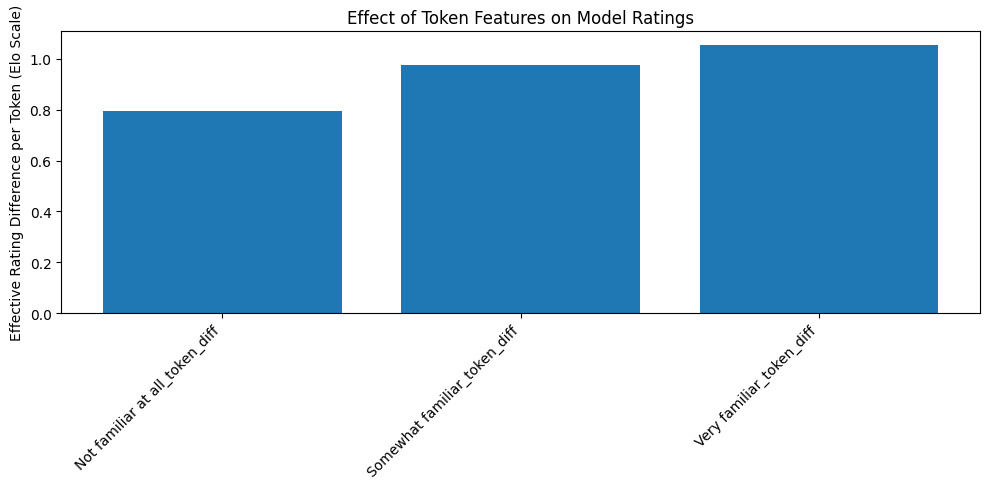

In [7]:
familiarity_token_results, _ = compute_results_for_features(df, feature_cols=token_diff_feature_cols)

labels, values = [], []
for idx, feat in enumerate(token_diff_feature_cols):
    value = familiarity_token_results["coeffs"][idx] * (400 / np.log(10))
    labels.append(feat)
    values.append(value)
    print(f"{feat}: {value}")

plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Effective Rating Difference per Token (Elo Scale)")
plt.title("Effect of Token Features on Model Ratings")
plt.tight_layout()
plt.show()

Broken down by AI familiarity, we see that the "Somewhat familiar" bucket, which is the largest segment of users, has a very close token difference coefficient to the overall one fit previously. However, it's interesting to see that those with no AI familiarity actually have the weakest preference towards longer responses, and those very familiar with AI have the strongest preference for longer responses.

### Effect of AI Familiarity

Next, we examine the impact of AI familiarity on preferences towards models. We again have one standard Bradley-Terry strength coefficient per model, but now we add three additional "offset" coefficients per model, which represent the increase or decrease in the model's win probability depending on the voter's level of familiarity with AI. In other words, we encode the voter's familiarity using one-hot encoding and apply an analogous Bradley-Terry regression with a linear offset as in the case of capturing the effect of model verbosity.

L-BFGS finished in 35 iterations.
  Final Loss: 0.623062
  Rel F Diff: 9.99e-16 (tol=1e-15)
  Grad Norm:  6.04e-10 (tol=1e-15)


<module 'matplotlib.pyplot' from '/Users/clayton/repos/arena-rank/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

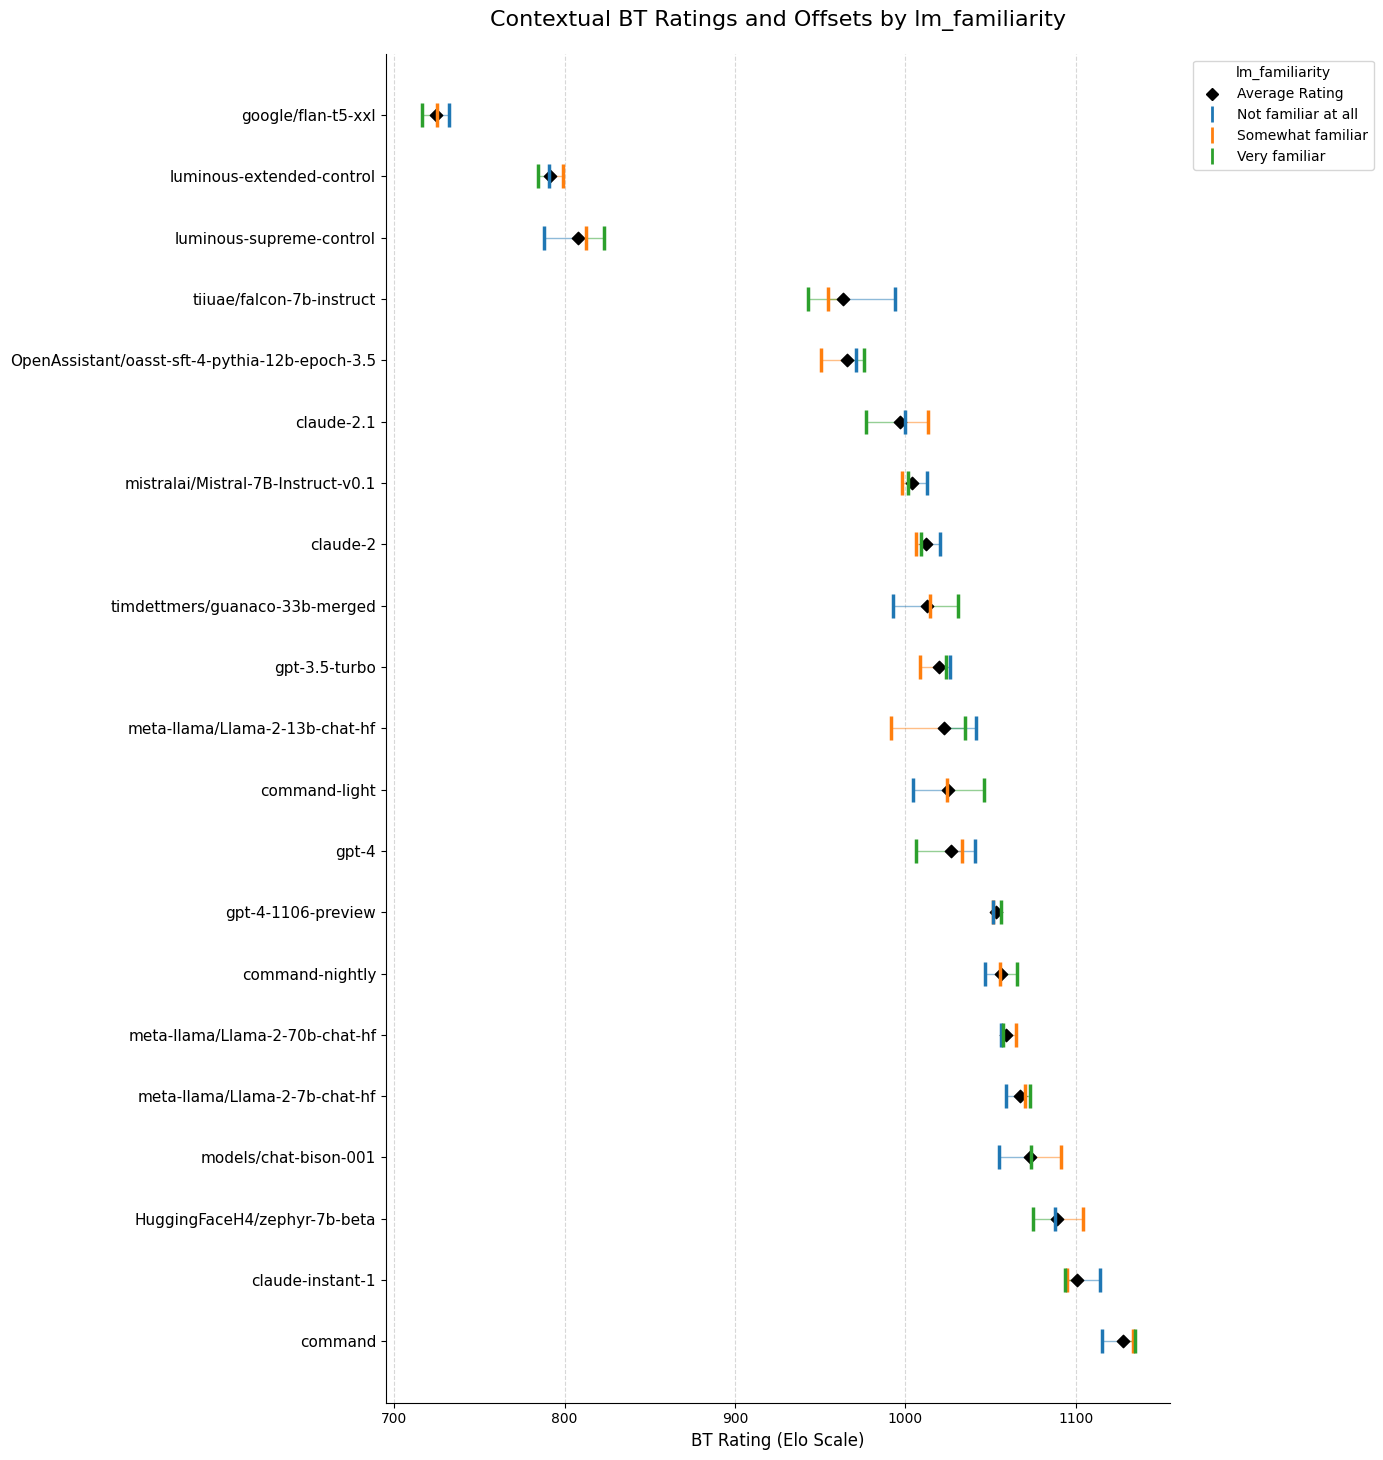

In [8]:
df, model_feature_cols = add_per_model_feature_cols(df, col_context=feature)
offset_results, offset_dataset = compute_results_for_features(df, feature_cols=model_feature_cols)
plot_prism_results(offset_results, model_feature_cols, offset_dataset.competitors, category_label=feature)

While it would be possible for all familiarity offsets to be zero if voters of all familiarity levels voted identically, the results indicate that the "effective strength" of models varies depending on the voter's level of AI familiarity. For example, the `command-lite` model is judged the highest by those most familiar with AI, and lowest by the least familiar, while `gpt-4` exhibits the exact opposite trend. Also interesting is that some models like `gpt-4-1106-preview` have very tightly clustered ratings, indicating that users across each segment roughly prefer it equally, but several models like `Llama-2-13b-chat` and `falcon-7b-instruct` have very large discrepancies. Some of this could also be noise due to small sample sizes but it's an interesting thread to investigate. We hope the Arena-Rank package makes this type of study more accessible!